# This Notebook was intended for LED calibration

In [3]:
'''
Load Package and define global variables
'''

import uproot
print(uproot.__version__)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import re
import matplotlib.patches as patches

from numpy import concatenate

import sys
sys.path.append("../src/") # go to parent dir

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams.update({'font.size': 14})

DATA_DIR='../data/'
ADC_TO_MV=2000/(2**14-1)


4.1.9


In [4]:
"""
defined a list of LED runs
"""

labels = [7.65, 7.70, 7.75, 7.80]
file_list = [
    "led_optHV_5dB_7.65V_220919T1727.root",
    "led_optHV_5dB_7.70V_220919T1718.root",
    "led_optHV_5dB_7.75V_220919T1715.root",
    "led_optHV_5dB_7.80V_220919T1711.root",
]

In [5]:
"""
Open one of the files
Check out a random waveform before doing any analysis
"""
f = uproot.open('../data/%s' % file_list[0])
t=f['daq']
raw = t['adc_b3_ch8'].array(library='np')

# this index iterates every times you run the next cell
this_i=0

94
71


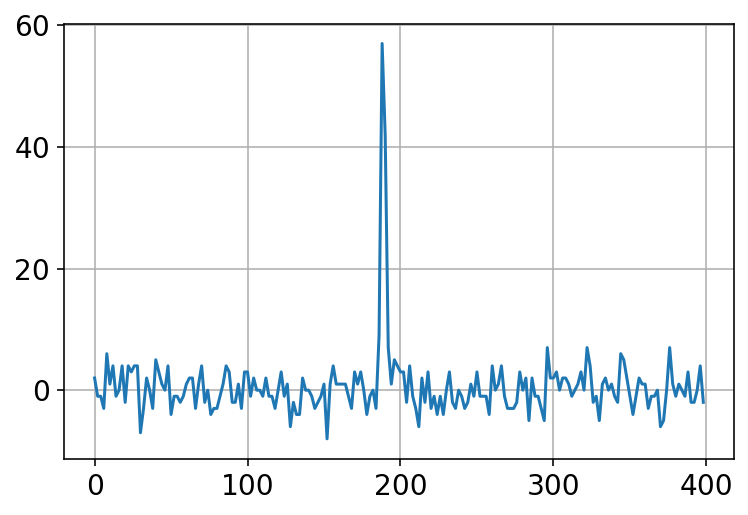

In [76]:
"""
A waveform that has a LED pulse interests me
"""
for i in range(this_i+1, 1000):
    a=raw[i]
    a = np.median(a)-a
    if np.max(a)>50: 
        t = np.linspace(0, (len(a)-1)*2, len(a))
        plt.plot(t, a)
        plt.grid()
        this_i=i
        print(this_i)
        break

In [6]:
"""
Load the data from the files
"""

event_id = {}
ch_id ={}
ch_names={} #active channel names
adc = {} # raw
for i, v in enumerate(labels):
    print('processing ', labels[i],'V')
    path = DATA_DIR + file_list[i]
    f = uproot.open(path)
    t = f['daq']
    event_id[v] =  t['event_id'].array(library='np')

    var_names = []
    ch_id[v] = []
    for ch_name in t.keys():
        if ch_name[0:4]=='adc_':
            var_names.append(ch_name)
            tmp = re.findall(r'\d+', ch_name)
            ch_id[v].append( int(tmp[0])*100+int(tmp[1]) )
    ch_names[v] = var_names
    adc[v] =  t.arrays(var_names, library='np')

processing  7.65 V
processing  7.7 V
processing  7.75 V
processing  7.8 V


In [7]:
"""
Define a map: ch_id -> ch_name
where ch_id is a int, and ch_name is a str
For example, 101 is adc_b1_ch1. 200 is adc_b2_ch0. 315 is adc_b3_ch15. You see the pattern?
"""
v=7.80
map_ch_name= dict(zip(ch_id[v], ch_names[v]))
print(map_ch_name)

{210: 'adc_b2_ch10', 307: 'adc_b3_ch7', 109: 'adc_b1_ch9', 103: 'adc_b1_ch3', 214: 'adc_b2_ch14', 207: 'adc_b2_ch7', 104: 'adc_b1_ch4', 206: 'adc_b2_ch6', 107: 'adc_b1_ch7', 112: 'adc_b1_ch12', 205: 'adc_b2_ch5', 315: 'adc_b3_ch15', 211: 'adc_b2_ch11', 208: 'adc_b2_ch8', 308: 'adc_b3_ch8', 301: 'adc_b3_ch1', 310: 'adc_b3_ch10', 110: 'adc_b1_ch10', 102: 'adc_b1_ch2', 304: 'adc_b3_ch4', 201: 'adc_b2_ch1', 305: 'adc_b3_ch5', 300: 'adc_b3_ch0', 202: 'adc_b2_ch2', 111: 'adc_b1_ch11', 313: 'adc_b3_ch13', 113: 'adc_b1_ch13', 212: 'adc_b2_ch12', 114: 'adc_b1_ch14', 200: 'adc_b2_ch0', 105: 'adc_b1_ch5', 309: 'adc_b3_ch9', 213: 'adc_b2_ch13', 209: 'adc_b2_ch9', 311: 'adc_b3_ch11', 106: 'adc_b1_ch6', 115: 'adc_b1_ch15', 101: 'adc_b1_ch1', 312: 'adc_b3_ch12', 306: 'adc_b3_ch6', 314: 'adc_b3_ch14', 108: 'adc_b1_ch8', 302: 'adc_b3_ch2', 303: 'adc_b3_ch3', 204: 'adc_b2_ch4', 203: 'adc_b2_ch3'}


In [8]:
"""
Function that calc some variables at channel-level
"""
def calc_ch_vars(adc, ch, n_events=10000, roi_start_ns=264, roi_length=40, peak_cut=2):
    """
    adc: list of array, shape=(n_ch, n_samples)
    ch: str. one ch_name
    """
    if roi_start_ns<0:
        roi_start_ns=0
    roi_end = roi_start_ns + roi_length
    adc_ch = adc[ch]
    max_n_events = len(adc_ch)
    n_samples = len(adc_ch[0])
    if n_events<=0:
        n_events=max_n_events
        
    pT_ns = np.zeros(n_events)
    peak_mV = np.zeros(n_events)
    led_H = np.zeros(n_events)
    led_C= np.zeros(n_events)
    for i in range(n_events):
        if i>=max_n_events:
            n_events=max_n_events
            break
        amp = np.median(adc_ch[i]) - adc_ch[i] # inverted
        peak = np.max(amp)
        peak_mV[i] = peak*adc_to_mV
        idx = np.argmax(np.median(adc_ch[i]) - adc_ch[i])
        pT_ns[i] = idx*2
        
        led_H[i] = np.max(amp[roi_start_ns//2:roi_end//2])*adc_to_mV
        led_C[i] = np.sum(amp[roi_start_ns//2:roi_end//2])*2*adc_to_mV/50
        
    freq_mask = (pT_ns>=roi_start_ns) & (pT_ns<roi_end) & (peak_mV >=peak_cut)
    freq =len(peak_mV[freq_mask])/n_events
    
    return dict(
        peak_time_ns=pT_ns,
        peak_mV=peak_mV,
        led_H=led_H,
        led_C=led_C,
        freq=freq
    )

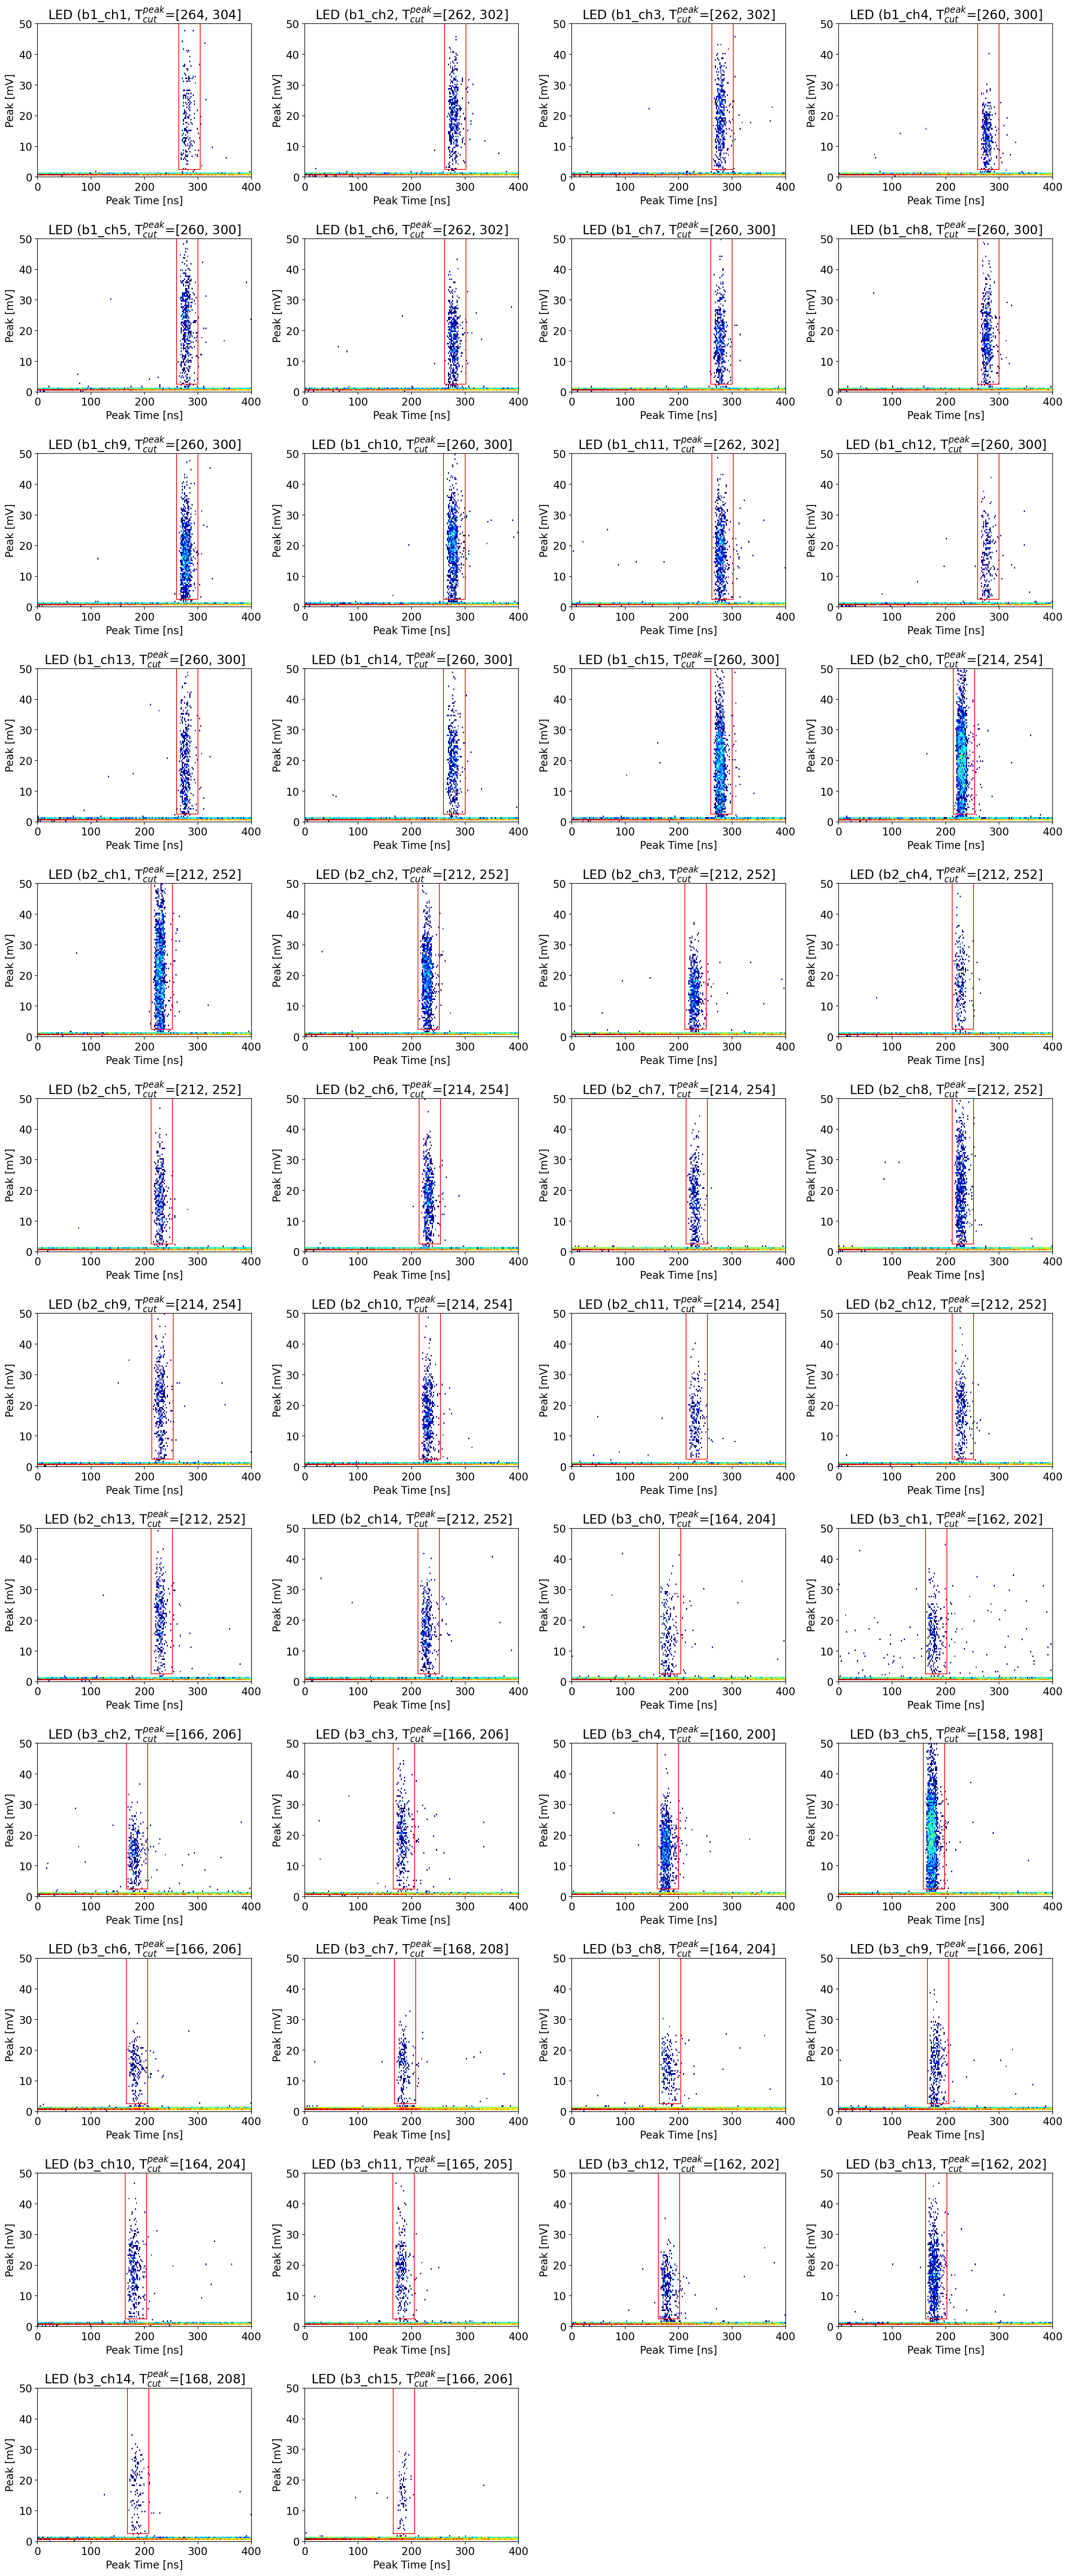

In [9]:
"""
find_peak_time will also make plots of peak_time vs height. 
"""
def find_peak_time(adc, ch_id, n_events=10000, roi_length=40, peak_cut=2):
    ch = map_ch_name[ch_id[0]]
    n_samples = len(adc[ch][0])
    n_ch = len(ch_id)
    ncols = 4
    nrows = int((n_ch-0.1)/ncols)+1
    plt.figure(figsize=[5*ncols,4*nrows])
    
    output={}
    for c, chID in enumerate(sorted(ch_id)):
        ch = map_ch_name[chID]
        rq = calc_ch_vars(adc, ch, n_events=10000, peak_cut=peak_cut)
        time_ns = rq['peak_time_ns']
        peak_mV = rq['peak_mV']
        
        ax = plt.subplot(nrows,ncols,c+1)
        xrange = (0, n_samples*2)
        yrange = [0, 50]
        plt.hist2d(time_ns, peak_mV, range=(xrange, yrange), bins=[n_samples, 100], 
                   norm=colors.LogNorm(), cmap='jet');
        
        # find proper roi window
        mask = peak_mV>=peak_cut
        if len(time_ns[mask])==0:
            roi_mid=100
        else:
            roi_mid = np.median(time_ns[mask])
        pre= roi_length//2-4
        roi_start_ns = roi_mid - pre
        output[ch]=int(roi_start_ns)
    
        rec_length=roi_length
        rect = patches.Rectangle((roi_start_ns, peak_cut), rec_length, yrange[1], 
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.title(r'LED (%s, T$^{peak}_{cut}$=[%d, %d]' % (ch[4:], roi_start_ns, roi_start_ns+roi_length))
        plt.xlabel('Peak Time [ns]')
        plt.ylabel('Peak [mV]')
    plt.tight_layout()
    plt.show()
    return output
    
v=7.75
pT_min = find_peak_time(adc[v], ch_id[v], n_events=10000, roi_length=40, peak_cut=2.5)


In [10]:
pT_min

{'adc_b1_ch1': 264,
 'adc_b1_ch2': 262,
 'adc_b1_ch3': 262,
 'adc_b1_ch4': 260,
 'adc_b1_ch5': 260,
 'adc_b1_ch6': 262,
 'adc_b1_ch7': 260,
 'adc_b1_ch8': 260,
 'adc_b1_ch9': 260,
 'adc_b1_ch10': 260,
 'adc_b1_ch11': 262,
 'adc_b1_ch12': 260,
 'adc_b1_ch13': 260,
 'adc_b1_ch14': 260,
 'adc_b1_ch15': 260,
 'adc_b2_ch0': 214,
 'adc_b2_ch1': 212,
 'adc_b2_ch2': 212,
 'adc_b2_ch3': 212,
 'adc_b2_ch4': 212,
 'adc_b2_ch5': 212,
 'adc_b2_ch6': 214,
 'adc_b2_ch7': 214,
 'adc_b2_ch8': 212,
 'adc_b2_ch9': 214,
 'adc_b2_ch10': 214,
 'adc_b2_ch11': 214,
 'adc_b2_ch12': 212,
 'adc_b2_ch13': 212,
 'adc_b2_ch14': 212,
 'adc_b3_ch0': 164,
 'adc_b3_ch1': 162,
 'adc_b3_ch2': 166,
 'adc_b3_ch3': 166,
 'adc_b3_ch4': 160,
 'adc_b3_ch5': 158,
 'adc_b3_ch6': 166,
 'adc_b3_ch7': 168,
 'adc_b3_ch8': 164,
 'adc_b3_ch9': 166,
 'adc_b3_ch10': 164,
 'adc_b3_ch11': 165,
 'adc_b3_ch12': 162,
 'adc_b3_ch13': 162,
 'adc_b3_ch14': 168,
 'adc_b3_ch15': 166}

In [82]:
my_ch_id = [101, 102, 103, 104, 105, 106, 107, 108, 109,
           110, 111, 112, 113, 114, 115,
           200, 201, 202, 203, 204, 205, 206, 207, 208,
           209, 210, 211, 212, 213, 214,
           300, 301, 302, 303,
            304, 305, 306, 307,
            308, 309, 310, 311,
            312, 313, 314, 315]

In [83]:
%%time
"""
Calculate occupancy
This block may a while
"""
roi_length=40

freq = {}
for v in labels:
    freq[v]={}
    print('processing v=%.2f' % v)
    for i in sorted(ch_id[v]):
        ch=map_ch_name[i]
        rq = calc_ch_vars(adc[v], ch=ch, n_events=40000, 
                            roi_start_ns=pT_min[ch], roi_length=roi_length, peak_cut=2)
        freq[v][ch]=rq['freq']

    

good_intensity={}
for i in my_ch_id:
    ch=map_ch_name[i]
    for v in sorted(labels):
        if freq[v][ch]>=0.01 and freq[v][ch]<0.05:
            print(ch, '\t', freq[v][ch], ' (v=%.2f)'%v, '\t <=')
            good_intensity[ch] = v
            break


processing v=7.65
processing v=7.70
processing v=7.75
processing v=7.80
adc_b1_ch1 	 0.0191  (v=7.75) 	 <=
adc_b1_ch2 	 0.010325  (v=7.65) 	 <=
adc_b1_ch3 	 0.0124  (v=7.65) 	 <=
adc_b1_ch4 	 0.03575  (v=7.75) 	 <=
adc_b1_ch5 	 0.012175  (v=7.65) 	 <=
adc_b1_ch6 	 0.011  (v=7.65) 	 <=
adc_b1_ch7 	 0.012125  (v=7.65) 	 <=
adc_b1_ch8 	 0.010425  (v=7.65) 	 <=
adc_b1_ch9 	 0.0239  (v=7.65) 	 <=
adc_b1_ch10 	 0.02315  (v=7.65) 	 <=
adc_b1_ch11 	 0.017175  (v=7.65) 	 <=
adc_b1_ch12 	 0.023775  (v=7.75) 	 <=
adc_b1_ch13 	 0.01065  (v=7.65) 	 <=
adc_b1_ch14 	 0.012225  (v=7.65) 	 <=
adc_b1_ch15 	 0.039075  (v=7.65) 	 <=
adc_b2_ch1 	 0.03895  (v=7.65) 	 <=
adc_b2_ch2 	 0.024  (v=7.65) 	 <=
adc_b2_ch3 	 0.0146  (v=7.65) 	 <=
adc_b2_ch4 	 0.02915  (v=7.75) 	 <=
adc_b2_ch5 	 0.040425  (v=7.75) 	 <=
adc_b2_ch6 	 0.01315  (v=7.65) 	 <=
adc_b2_ch7 	 0.0407  (v=7.75) 	 <=
adc_b2_ch8 	 0.017  (v=7.65) 	 <=
adc_b2_ch9 	 0.04185  (v=7.75) 	 <=
adc_b2_ch10 	 0.01255  (v=7.65) 	 <=
adc_b2_ch11 	 0.0278  (

In [84]:
ChName2LedVoltageMap = {
    'adc_b1_ch1':  7.70,
    'adc_b1_ch2':  7.70,
    'adc_b1_ch3':  7.70,
    'adc_b1_ch4':  7.70,
    'adc_b1_ch5':  7.70,
    'adc_b1_ch6':  7.70,
    'adc_b1_ch7':  7.70,
    'adc_b1_ch8':  7.70,
    'adc_b1_ch9':  7.70,
    'adc_b1_ch10': 7.70,
    'adc_b1_ch11': 7.70,
    'adc_b1_ch12': 7.70,
    'adc_b1_ch13': 7.70,
    'adc_b1_ch14': 7.70,
    'adc_b1_ch15': 7.70,
    'adc_b2_ch0':  7.70,
    'adc_b2_ch1':  7.70,
    'adc_b2_ch2':  7.70,
    'adc_b2_ch3':  7.70,
    'adc_b2_ch4':  7.70,
    'adc_b2_ch5':  7.70,
    'adc_b2_ch6':  7.70,
    'adc_b2_ch7':  7.70,
    'adc_b2_ch8':  7.70,
    'adc_b2_ch9':  7.70,
    'adc_b2_ch10': 7.70,
    'adc_b2_ch11': 7.70,
    'adc_b2_ch12': 7.70,
    'adc_b2_ch13': 7.70,
    'adc_b2_ch14': 7.70,
    
    "adc_b3_ch0": 7.70,
    "adc_b3_ch1": 7.70,
    "adc_b3_ch2": 7.70,
    "adc_b3_ch3": 7.70,
    "adc_b3_ch4": 7.70,
    "adc_b3_ch5": 7.70,
    "adc_b3_ch6": 7.70,
    "adc_b3_ch7": 7.70,
    "adc_b3_ch8": 7.70,
    "adc_b3_ch9": 7.70,
    "adc_b3_ch10": 7.70,
    "adc_b3_ch11": 7.70,
    "adc_b3_ch12": 7.70,
    "adc_b3_ch13": 7.70,
    "adc_b3_ch14": 7.70,
    "adc_b3_ch15": 7.75,
}
for ch, v in good_intensity.items():
    ChName2LedVoltageMap[ch]=v

ChName2PMTMap = {
    'adc_b1_ch1': 'bt_p1',
    'adc_b1_ch2': 'bt_p2',
    'adc_b1_ch3': 'bt_p3',
    'adc_b1_ch4': 'bt_p4',
    'adc_b1_ch5': 'bt_p5',
    'adc_b1_ch6': 'bt_p6',
    'adc_b1_ch7': 'bt_p7',
    'adc_b1_ch8': 'bt_p8',
    'adc_b1_ch9': 'bt_p9',
    'adc_b1_ch10':'bt_p10',
    'adc_b1_ch11':'bt_p11',
    'adc_b1_ch12':'bt_p12',
    'adc_b1_ch13':'bt_p13',
    'adc_b1_ch14':'bt_p14',
    'adc_b1_ch15':'bt_p15',
    'adc_b2_ch0': 'bt_p16',
    'adc_b2_ch1': 'bt_p17',
    'adc_b2_ch2': 'bt_p18',
    'adc_b2_ch3': 'bt_p19',
    'adc_b2_ch4': 'bt_p20',
    'adc_b2_ch5': 'bt_p21',
    'adc_b2_ch6': 'bt_p22',
    'adc_b2_ch7': 'bt_p23',
    'adc_b2_ch8': 'bt_p24',
    'adc_b2_ch9': 'bt_p25',
    'adc_b2_ch10':'bt_p26',
    'adc_b2_ch11':'bt_p27',
    'adc_b2_ch12':'bt_p28',
    'adc_b2_ch13':'bt_p29',
    'adc_b2_ch14':'bt_p30',
    
    "adc_b3_ch0": "b1_p1",
    "adc_b3_ch1": "b1_p2",
    "adc_b3_ch2": "b1_p3",
    "adc_b3_ch3": "b1_p4",
    "adc_b3_ch4": "b2_p1",
    "adc_b3_ch5": "b2_p2",
    "adc_b3_ch6": "b2_p3",
    "adc_b3_ch7": "b2_p4",
    "adc_b3_ch8": "b3_p1",
    "adc_b3_ch9": "b3_p2",
    "adc_b3_ch10":"b3_p3",
    "adc_b3_ch11":"b3_p4",
    "adc_b3_ch12":"b4_p1",
    "adc_b3_ch13":"b4_p2",
    "adc_b3_ch14":"b4_p3",
    "adc_b3_ch15":"b4_p4",
}


ChName2HVMap = {
        'adc_b1_ch1':  1900,
        'adc_b1_ch2':  1950,
        'adc_b1_ch3':  2000,
        'adc_b1_ch4':  2200,
        'adc_b1_ch5':  1950,
        'adc_b1_ch6':  1800,
        'adc_b1_ch7':  2100,
        'adc_b1_ch8':  2100,
        'adc_b1_ch9':  2125,
        'adc_b1_ch10': 1975,
        'adc_b1_ch11': 2000,
        'adc_b1_ch12': 1900,
        'adc_b1_ch13': 2125,
        'adc_b1_ch14': 2000,
        'adc_b1_ch15': 2025,
        'adc_b2_ch0':  1900,
        'adc_b2_ch1':  2125,
        'adc_b2_ch2':  2150,
        'adc_b2_ch3':  1900,
        'adc_b2_ch4':  2100,
        'adc_b2_ch5':  2000,
        'adc_b2_ch6':  1800,
        'adc_b2_ch7':  1925,
        'adc_b2_ch8':  2050,
        'adc_b2_ch9':  2000,
        'adc_b2_ch10': 1850,
        'adc_b2_ch11': 1850,
        'adc_b2_ch12': 2050,
        'adc_b2_ch13': 2000,
        'adc_b2_ch14': 2025,
        "adc_b3_ch0":  2075,
        "adc_b3_ch1":  2225,
        "adc_b3_ch2":  2075,
        "adc_b3_ch3":  1950,
        "adc_b3_ch4":  2225,
        "adc_b3_ch5":  2225,
        "adc_b3_ch6":  1950,
        "adc_b3_ch7":  1850,
        "adc_b3_ch8":  1975,
        "adc_b3_ch9":  1900,
        "adc_b3_ch10": 2075,
        "adc_b3_ch11": 2000,
        "adc_b3_ch12": 2100,
        "adc_b3_ch13": 1950,
        "adc_b3_ch14": 2025,
        "adc_b3_ch15": 2250,
} 

N_CHAN=len(ChName2LedVoltageMap)
CH_NAMES = list(ChName2LedVoltageMap.keys())

In [85]:
# where to decide if it's a SPE in peak height. unit: mV
SPE_PEAK_CUT=2.5


In [86]:
%%time
"""
Calcualte charge vs height
This block will take a while
"""

led_H={}
led_C={}
for i in my_ch_id:
    ch=map_ch_name[i]
    print('processing', ch, '...' )
    v = ChName2LedVoltageMap[ch]
    rq = calc_ch_vars(adc[v], ch, n_events=100000, 
                        roi_start_ns=pT_min[ch], roi_length=50, peak_cut=SPE_PEAK_CUT)
    led_H[ch] = rq['led_H']
    led_C[ch] = rq['led_C']


processing adc_b1_ch1 ...
processing adc_b1_ch2 ...
processing adc_b1_ch3 ...
processing adc_b1_ch4 ...
processing adc_b1_ch5 ...
processing adc_b1_ch6 ...
processing adc_b1_ch7 ...
processing adc_b1_ch8 ...
processing adc_b1_ch9 ...
processing adc_b1_ch10 ...
processing adc_b1_ch11 ...
processing adc_b1_ch12 ...
processing adc_b1_ch13 ...
processing adc_b1_ch14 ...
processing adc_b1_ch15 ...
processing adc_b2_ch0 ...
processing adc_b2_ch1 ...
processing adc_b2_ch2 ...
processing adc_b2_ch3 ...
processing adc_b2_ch4 ...
processing adc_b2_ch5 ...
processing adc_b2_ch6 ...
processing adc_b2_ch7 ...
processing adc_b2_ch8 ...
processing adc_b2_ch9 ...
processing adc_b2_ch10 ...
processing adc_b2_ch11 ...
processing adc_b2_ch12 ...
processing adc_b2_ch13 ...
processing adc_b2_ch14 ...
processing adc_b3_ch0 ...
processing adc_b3_ch1 ...
processing adc_b3_ch2 ...
processing adc_b3_ch3 ...
processing adc_b3_ch4 ...
processing adc_b3_ch5 ...
processing adc_b3_ch6 ...
processing adc_b3_ch7 ...
p

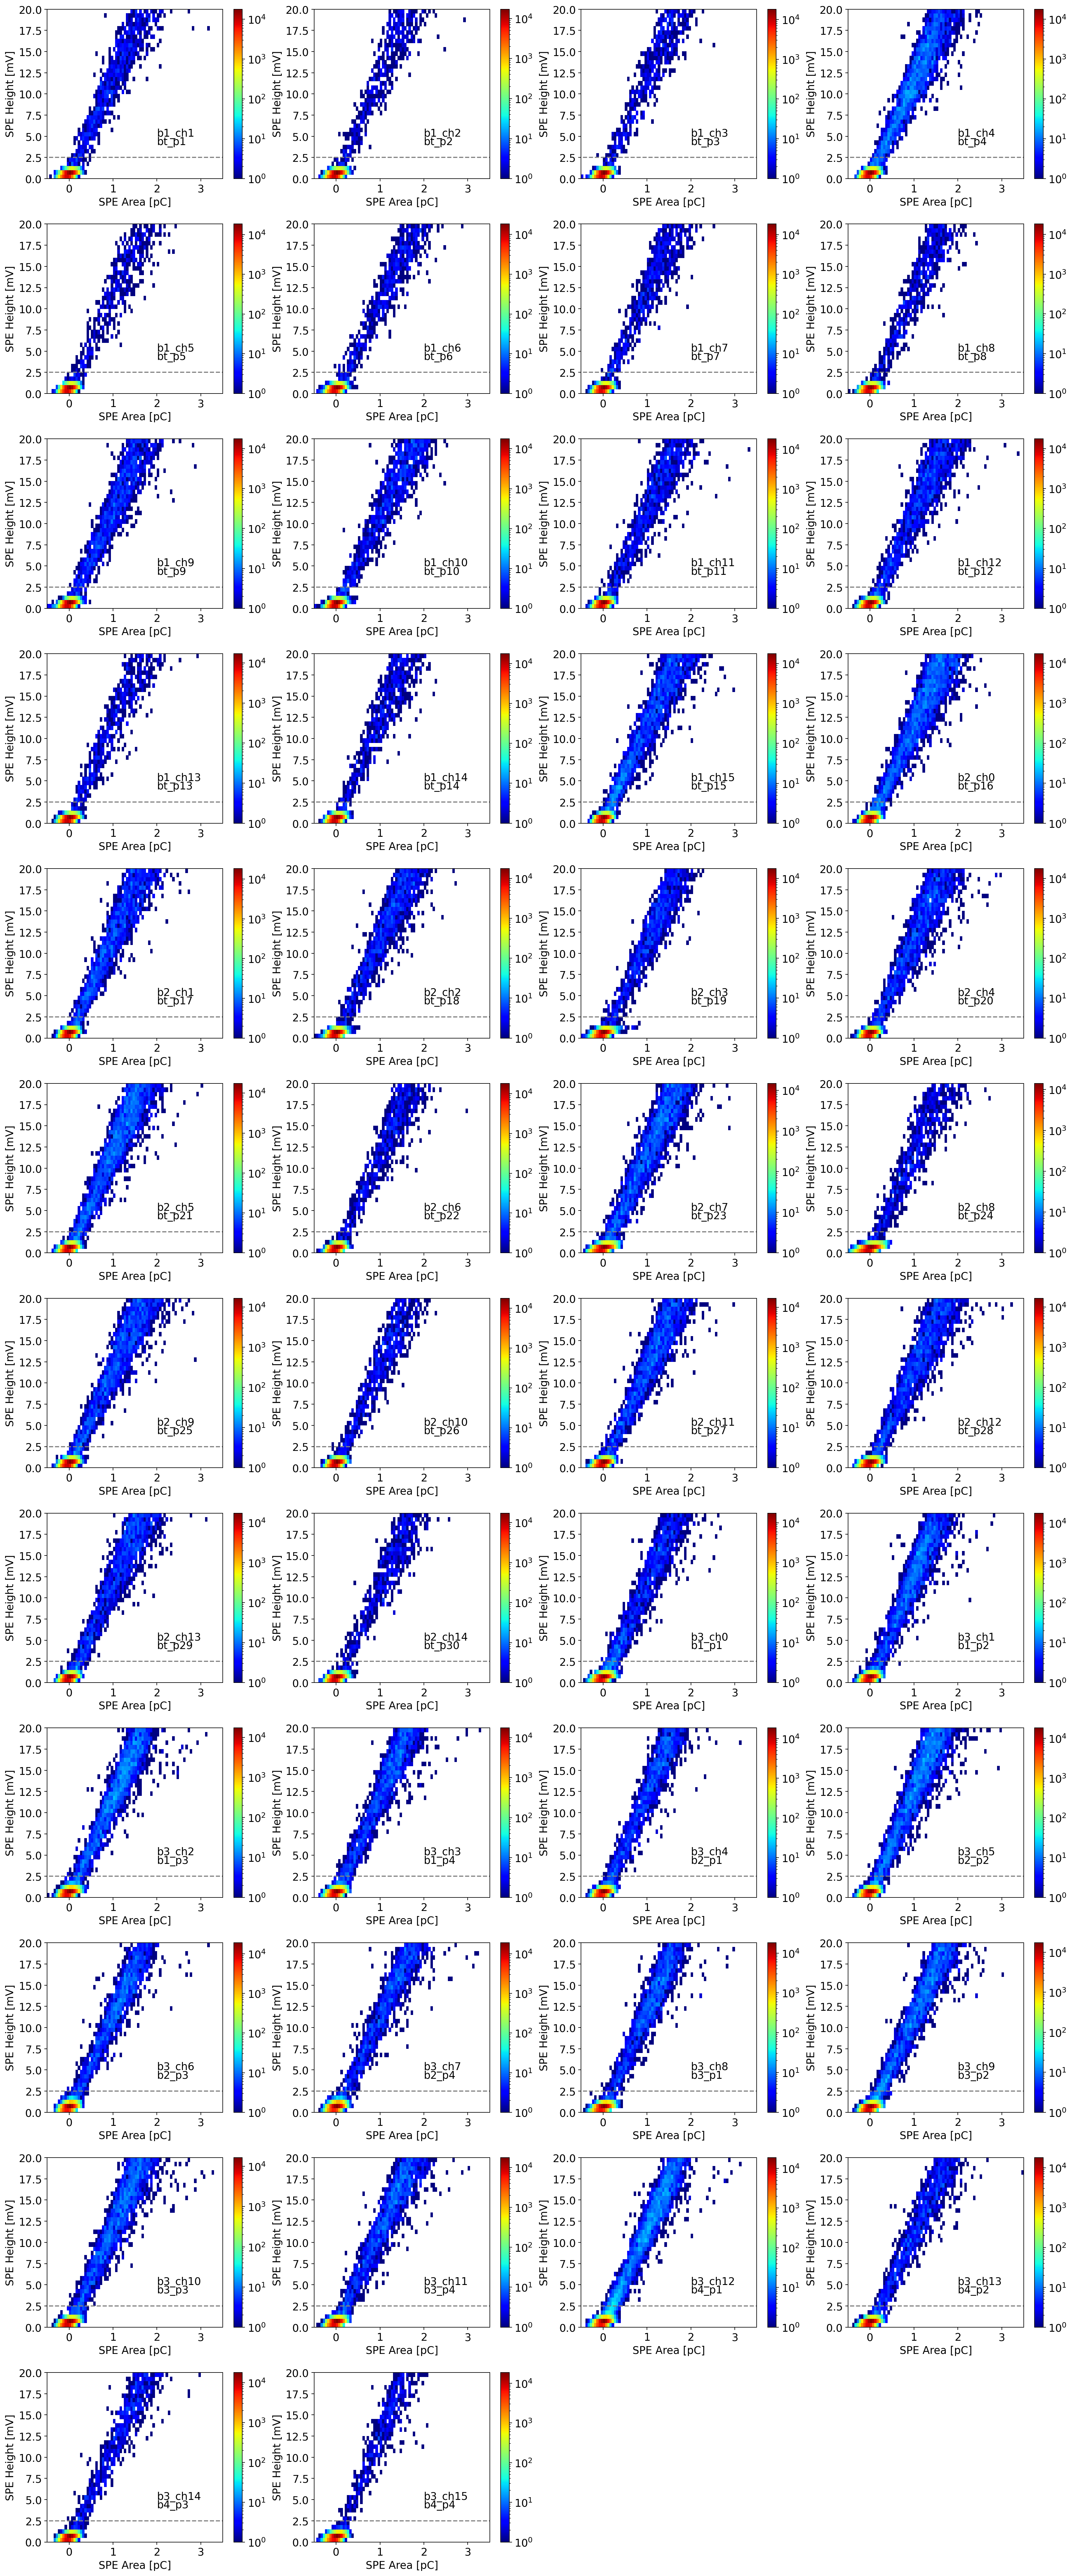

In [87]:
def plot_spe_AvsH():

    ncols = 4
    nrows = int((len(my_ch_id)-0.1)/ncols)+1
    plt.figure(figsize=[5*ncols,4*nrows], dpi=90)
    for c, i in enumerate(my_ch_id):
        ch=map_ch_name[i]
        ax = plt.subplot(nrows,ncols,c+1)

        C = led_C[ch]
        H = led_H[ch]
        h = plt.hist2d(C, H, bins=80, range=[[-0.5, 3.5],[0, 40]], 
                       cmap='jet', norm=colors.LogNorm());
        plt.hlines(SPE_PEAK_CUT, -1, 5, colors='grey', linestyle='dashed')
        plt.colorbar(h[3])
        plt.xlabel('SPE Area [pC]')
        plt.ylabel('SPE Height [mV]')
        plt.xlim(-0.5, 3.5)
        plt.ylim(0, 20)

        plt.text(2, 5, ch[4:])
        plt.text(2, 4, ChName2PMTMap[ch])
        #print("%dV, Occupancy: %.2f" % (v, occupancy))
plot_spe_AvsH()
plt.tight_layout()
plt.show()

In [88]:
from scipy.optimize import curve_fit

def gauss(x, mu, sigma, A):
    arg = (x-mu)/sigma
    N = A/np.sqrt(2*np.pi)/sigma
    return N*np.exp(-0.5*arg*arg)

def calc_chi2(func, xdata, ydata, popt):
    y = func(xdata, popt[0], popt[1], popt[2])
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)

def chi2_fit(h, fit_range, p0=[1, 1, 1]):
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    tot = np.trapz(ydata[fit_mask], xdata[fit_mask])
    #tot = np.sum(ydata)
    p0[2]=tot
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = gauss(x, popt[0], popt[1], popt[2])
    
    chi2 = calc_chi2(gauss, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-2    
    
    err = np.diag(pcov)
    err = np.sqrt(err)
    
    return dict(
        x=x, 
        y=y,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

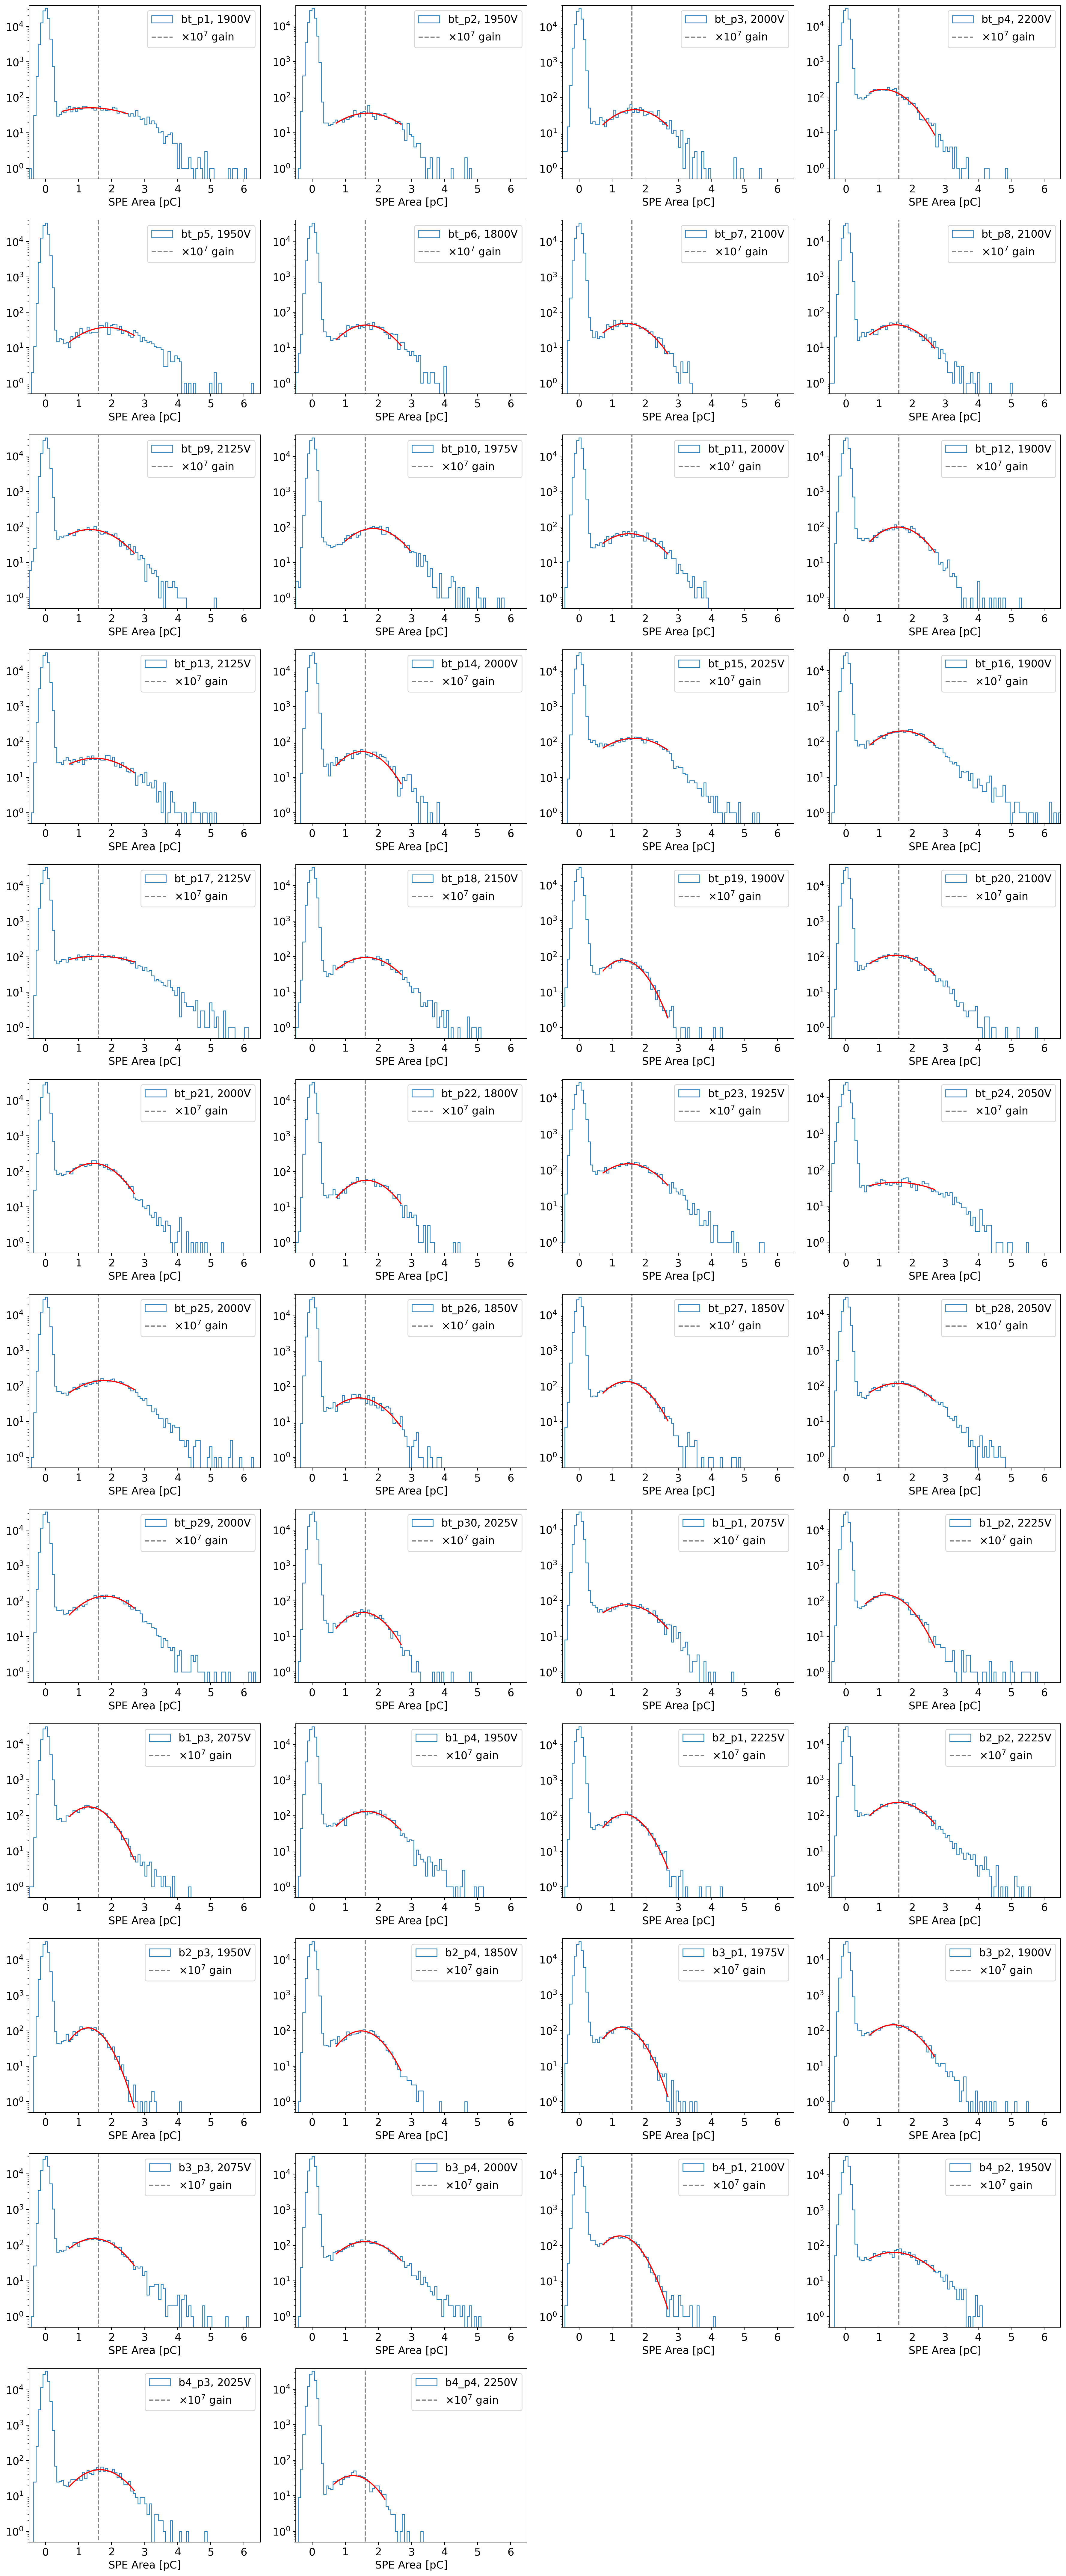

In [95]:
import pandas as pd
df = pd.DataFrame({
    'ch_id': [], 
    'ch_name': [],
    'pmt': [],
    'spe_mean': [],
    'spe_width': [],
    'chi2': [],
    'dof': [],
    'spe_mean_err': [],
    'spe_width_err': [],
    'HV': []
})


do_spe_fit=True

def plot_spe_A():
    ncols = 4
    nrows = int((len(my_ch_id)-0.1)/ncols)+1
    plt.figure(figsize=[5*ncols,4*nrows], dpi=90)
    for c, i in enumerate(my_ch_id):
        ch=map_ch_name[i]
        ax = plt.subplot(nrows,ncols,c+1)
        C = led_C[ch]
        H = led_H[ch]
        mask=H>-SPE_PEAK_CUT
        h = plt.hist(C[mask], bins=100, range=[-0.5, 6.5], histtype='step', 
                     label='%s, %dV' % (ChName2PMTMap[ch], ChName2HVMap[ch]));
        if 'bt_p1' == ChName2PMTMap[ch]:
            fit_range=[0.5, 2.5]
            p0 = [1.5, 0.6, 1000]
        elif 'bt_p10' == ChName2PMTMap[ch]:
            fit_range=[1, 3]
            p0 = [1.5, 0.3, 1000]
        elif 'b1_p2' == ChName2PMTMap[ch]:
            fit_range=[0.55, 2.7]
            p0 = [1.5, 0.3, 1000]
        elif 'b4_p4' == ChName2PMTMap[ch]:
            fit_range=[0.6, 2.2]
            p0 = [1.1, 0.2, 1000]
        else:
            fit_range=[0.7, 2.7]
            p0=[1.6, 0.4, 1000]
        #print(ChName2PMTMap[ch])
        if do_spe_fit:
            fit = chi2_fit(h, fit_range=fit_range, p0=p0)
            plt.plot(fit['x'], fit['y'], color='red')
            df.loc[len(df.index)]={
                'ch_id': i, 
                'ch_name': ch,
                'pmt': ChName2PMTMap[ch],
                'spe_mean': fit['popt'][0],
                'spe_width': fit['popt'][1],
                'chi2': fit['chi2'],
                'dof': fit['dof'],
                'spe_mean_err': fit['err'][0],
                'spe_width_err': fit['err'][1],
                'HV': ChName2HVMap[ch]
            }
        
        plt.yscale('log')
        plt.xlabel('SPE Area [pC]')
        plt.xlim(-0.5, 6.5)
        plt.ylim(0.5, np.max(h[0]*1.2))
        plt.vlines(1.6, 0, 1e5, color='grey', linestyle='dashed', label=r'$\times 10^7$ gain')
        plt.legend()

plot_spe_A()
plt.tight_layout()
plt.show()

In [96]:
plt.savefig('bnl1t_spe_fit_results_220919.png')
df.to_csv('bnl1t_spe_fit_results_220919.csv', index=False)

<Figure size 432x288 with 0 Axes>

# Linearity

In [38]:
labels=[2000, 2100, 2200]
file_list=[
#     "test_led_b1_p1_p2_1900V_2Vpp_400ns_2kHz_7.85V_5dB_220809T2030.root",
    "test_led_b1_p1_p2_2000V_2Vpp_400ns_2kHz_7.85V_5dB_220809T2027.root",
    "test_led_b1_p1_p2_2100V_2Vpp_400ns_2kHz_7.85V_5dB_220809T2032.root",
    "test_led_b1_p1_p2_2200V_2Vpp_400ns_2kHz_7.85V_5dB_220809T2034.root",
]

In [39]:
event_id = {}
ch_id ={}
ch_names={} #active channel names
adc = {} # raw
for i, v in enumerate(labels):
    print('processing ', labels[i],'V')
    path = DATA_DIR + file_list[i]
    f = uproot.open(path)
    t = f['daq']
    event_id[v] =  t['event_id'].array(library='np')

    var_names = []
    ch_id[v] = []
    for ch_name in t.keys():
        if ch_name[0:4]=='adc_':
            var_names.append(ch_name)
            tmp = re.findall(r'\d+', ch_name)
            ch_id[v].append( int(tmp[0])*100+int(tmp[1]) )
    ch_names[v] = var_names
    adc[v] =  t.arrays(var_names, library='np')

processing  2000 V
processing  2100 V
processing  2200 V


In [40]:
%%time
"""
Calcualte charge vs height
This block will take a while
"""

led_H={}
led_C={}
for v in labels:
    ch=map_ch_name[300]
    rq = calc_ch_vars(adc[v], ch, n_events=100000, 
                        roi_start_ns=pT_min[ch], roi_length=50, peak_cut=2)
    led_H[v] = rq['led_H']
    led_C[v] = rq['led_C']

CPU times: user 20.8 s, sys: 77.5 ms, total: 20.9 s
Wall time: 21 s


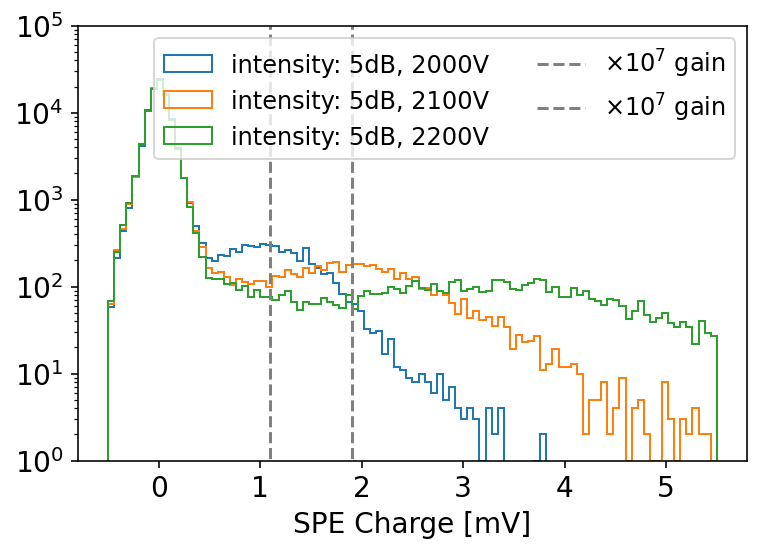

In [53]:
def plot_spe_charge():
    for v in labels:
        plt.hist(led_C[v], range=(-0.5, 5.5), bins=100, histtype='step',
                 label="intensity: 5dB, %2.fV" % v)
    plt.vlines(1.1, 0, 1e5, color='grey', linestyle='dashed', label=r'$\times 10^7$ gain')
    plt.vlines(1.9, 0, 1e5, color='grey', linestyle='dashed', label=r'$\times 10^7$ gain')
    plt.legend(fontsize=12, ncol=2)
    plt.yscale('log')
    plt.ylim([1, 1e5])
    plt.xlabel('SPE Charge [mV]')
    plt.show()

plot_spe_charge()

In [46]:
def gain_curve_3inch(x, const=-10.23, slope=0.005054):
    return np.exp(const + slope*x)*1e7

gain_curve(2025)/gain_curve(2000)

1.1346792365248133

# Compare multiple LED runs

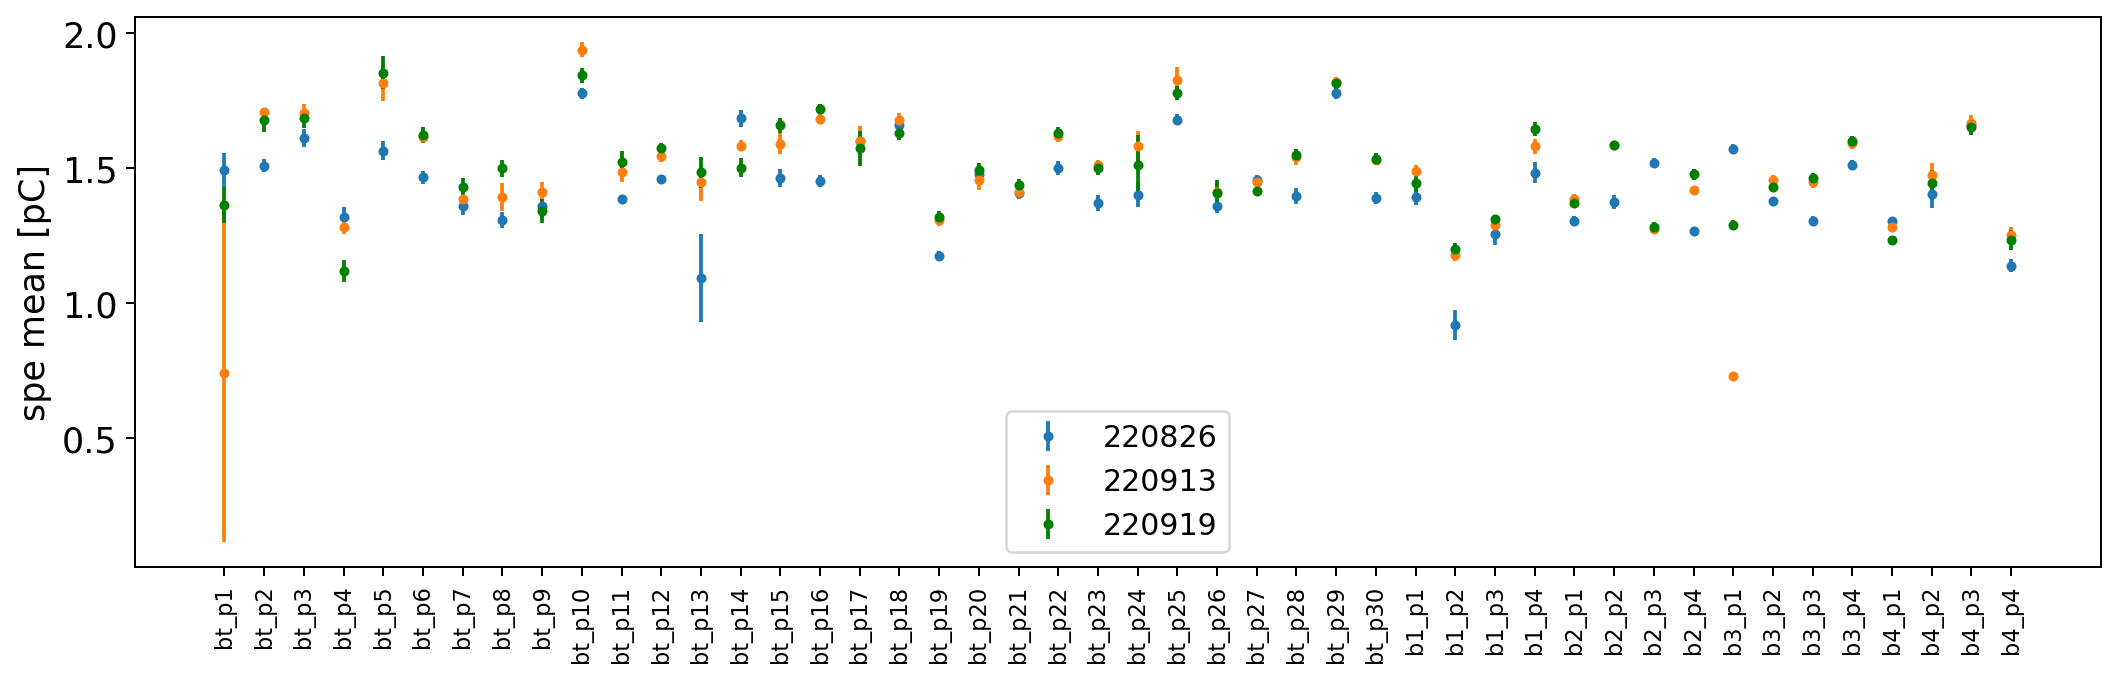

In [105]:
file_paths = [
    "bnl1t_spe_fit_results_220826.csv",
    "bnl1t_spe_fit_results_220913.csv",
    "bnl1t_spe_fit_results_220919.csv",
]

colors = ['tab:blue', 'tab:orange', 'green']
legs = ['220826', '220913', '220919']

fig = plt.figure(figsize=[12, 4], dpi=90)
# ax1 = plt.subplot(211)
# ax2 = plt.subplot(212, sharex = ax1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)
#ax1.get_shared_x_axes().join(ax1, ax2)
for i, f in enumerate(file_paths):
    df = pd.read_csv(f)
    pmt = df['pmt'].tolist() 
    spe_mean = df['spe_mean'].to_numpy() 
    spe_mean_err = df['spe_mean_err'].to_numpy() 
    plt.errorbar(pmt, spe_mean, yerr=spe_mean_err, label=legs[i],
                 color=colors[i], marker='.', linestyle="None")

plt.xticks(rotation=90, fontsize=9)
plt.ylabel('spe mean [pC]')
plt.tight_layout()
plt.legend(fontsize=12, loc='lower center')
plt.show()

In [74]:
df

,ch_name,pmt,spe_mean,spe_width,chi2,dof,spe_mean_err,spe_width_err,HV
0,adc_b1_ch1,bt_p1,1.494102,1.090892,27.496158,25,0.062935,0.121805,1900
1,adc_b1_ch2,bt_p2,1.508565,-0.580390,23.526023,25,0.024063,0.026974,1950
2,adc_b1_ch3,bt_p3,1.611699,-0.648355,31.360441,25,0.032238,0.042675,2000
3,adc_b1_ch4,bt_p4,1.318395,-0.711732,16.295117,25,0.036868,0.037938,2200
4,adc_b1_ch5,bt_p5,1.564198,-0.686437,24.487399,25,0.035575,0.048250,1950
